Discretize the Markovian continuous uncertainty
====================================
In this tutorial, we illustrate the Markov chain approximation for the Markovian inflow energy $X_t$. The generator function obtained in TS.py is used to train the Markov chain. 

In [1]:
import pandas
import numpy
from msppy.utils.plot import fan_plot
from msppy.discretize import Markovian
import matplotlib.pyplot as plt
gamma = numpy.array(pandas.read_csv(
    "./data/gamma.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
sigma = [
    numpy.array(pandas.read_csv(
        "./data/sigma_{}.csv".format(i),
        names=[0,1,2,3],
        index_col=0,
        skiprows=1,
    )) for i in range(12)
]
exp_mu = numpy.array(pandas.read_csv(
    "./data/exp_mu.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
inflow_initial = numpy.array([[55899.53854,7237.840244,14156.975,10551.62268]])
T = 12
def generator(random_state,size):
    inflow = numpy.empty([size,T,4])
    inflow[:,0,:] = inflow_initial
    for t in range(1,T):
        noise = numpy.exp(random_state.multivariate_normal(mean=[0]*4, cov=sigma[t%12],size=size))
        inflow[:,t,:] = noise * (
            (1-gamma[t%12]) * exp_mu[t%12]
            + gamma[t%12] * exp_mu[t%12]/exp_mu[(t-1)%12] * inflow[:,t-1,:]
        )
    return inflow

Use stochastic approximation to iteratively train a non-homogenuous four-dimensional Markov chain with one initial Markov states and one hundred Markov states from stage two on. We make 1000 iterations to train the Markov states and then 10000 iterations to train the transition matrix.

In [2]:
markovian = Markovian(
    f=generator, 
    n_Markov_states=[1]+[12]*(T-1), 
    n_sample_paths=1000)
Markov_states, transition_matrix = markovian.SA()

In [3]:
# stage 0: The initial four-dimensional inflow
Markov_states[0]

array([[55899.53854 ,  7237.840244, 14156.975   , 10551.62268 ]])

In [4]:
# stage 1: The trained 100 Markov states. Each column is a Markov state.
pandas.DataFrame(Markov_states[1]).head()

,0,1,2,3
0,34034.298626,11016.552131,7951.311828,8882.318490
1,36412.878436,11506.047866,5964.481436,7447.834372
2,38399.750403,16004.281509,9350.714828,15114.265304
3,43844.063768,11773.926925,10000.651229,9717.052932
4,47833.463679,9077.877217,12719.389894,13094.398061


In [5]:
# Stage 0: transition matrix always begins with [[1]] since the first stage is always
# assumed to be deterministic.
transition_matrix[0]

array([[1]])

In [6]:
# stage 1: transition matrix between the initial single Markov state 
# and the 100 Markov states in the second stage, so it is 1 by 100.
pandas.DataFrame(transition_matrix[1])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.027,0.011,0.015,0.07,0.181,0.024,0.136,0.197,0.051,0.138,0.05,0.1


In [7]:
# stage 2: transition matrix between the 100 Markov states in the second stage
# and the 100 Markov states in the third stage, so it is 100 by 100.
pandas.DataFrame(transition_matrix[2]).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.222222,0.000000,0.074074,0.333333,0.074074,0.185185,0.037037,0.074074,0.000000,0.000000,0.0,0.000000
1,0.181818,0.090909,0.181818,0.272727,0.090909,0.000000,0.000000,0.181818,0.000000,0.000000,0.0,0.000000
2,0.066667,0.200000,0.000000,0.133333,0.066667,0.133333,0.066667,0.200000,0.066667,0.000000,0.0,0.066667
3,0.100000,0.014286,0.071429,0.257143,0.257143,0.042857,0.014286,0.171429,0.014286,0.042857,0.0,0.014286
4,0.066298,0.016575,0.016575,0.193370,0.143646,0.160221,0.011050,0.215470,0.099448,0.038674,0.0,0.038674


Use the trained Markov state space and transition matrix to simulate inflow data. It is clear that the fan plot of the simulated sample path is very similar to that of the historical data (see TS.py).

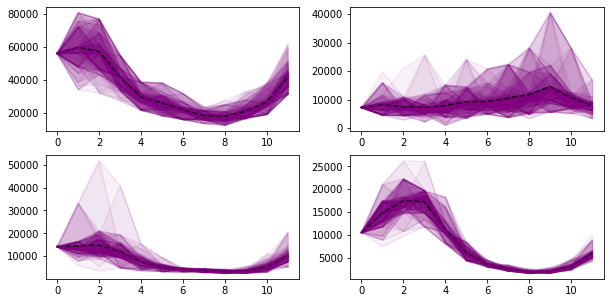

In [8]:
sim = markovian.simulate(100)
fig = plt.figure(figsize=(10,5))
ax = [None] * 4
for i in range(4):
    ax[i] = plt.subplot(221+i)
    fan_plot(sim[:,:,i],ax[i])

In the end, let us try all approaches to make MC approximation.

In [9]:
sim = [None] * 3
markovian = Markovian(
    f=generator, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.SAA()
sim[0] = markovian.simulate(100)

In [10]:
markovian = Markovian(
    f=generator, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.SA()
sim[1] = markovian.simulate(100)

In [11]:
markovian = Markovian(
    f=generator, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.RSA()
sim[2] = markovian.simulate(100)

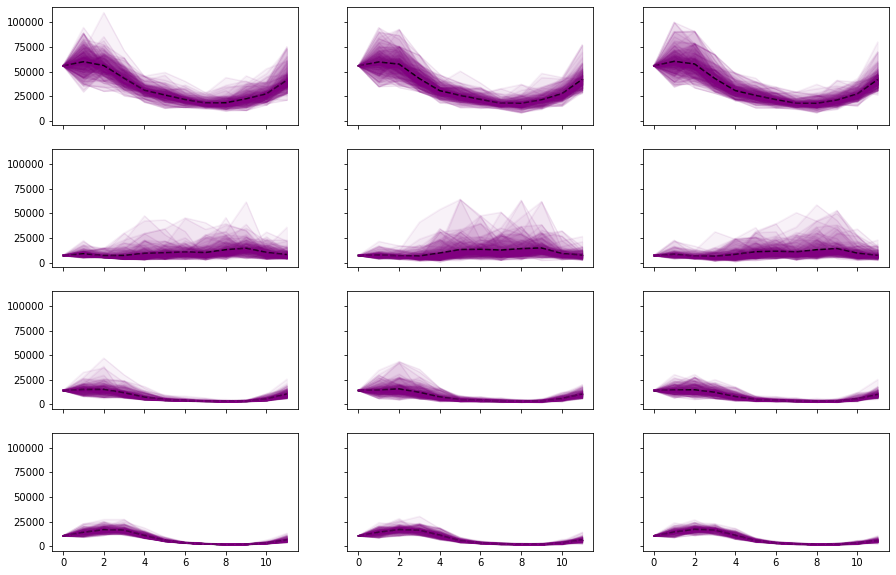

In [12]:
fig, ax = plt.subplots(4,3,figsize=(15,10), sharex=True, sharey=True)
for i in range(4):
    for j in range(3):
        fan_plot(sim[j][:,:,i], ax[i][j])

The above MCs are obtained coarsely and only for 12 stages. For your conveneince, in the directory of data/MC, we have output five fine-trained MCs for the whole 120-stage planning period. The five MCs correspond to the first five 